# Modelo 3: Random Forest

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns

In [34]:
X = pd.read_csv(r"c:\Users\USER\Downloads\x_train_final.csv")
y = X['target']

# Implementación inicial de un arbol de decisión

In [35]:
# Árbol CART con probabilidades
def gini_impurity(y):
    if y.size == 0: return 0.0
    p1 = np.mean(y==1); p0 = 1.0 - p1
    return 1.0 - (p0*p0 + p1*p1)

def _candidate_thresholds(x, max_candidates=50):
    vals = np.unique(x)
    if vals.size <= 1: return np.array([], dtype=np.float64)
    if vals.size == 2 and set(vals) == {0.0, 1.0}: return np.array([0.5], dtype=np.float64)
    mids = (vals[:-1] + vals[1:]) / 2.0
    if mids.size > max_candidates:
        idx = np.linspace(0, mids.size-1, max_candidates).astype(int)
        mids = mids[idx]
    return mids.astype(np.float64)

def best_split(X, y, feat_idx, min_leaf=20, max_candidates=50):
    n = y.size
    base = gini_impurity(y)
    best = {"gain":0.0, "j":None, "thr":None}
    for j in feat_idx:
        xj = X[:, j]
        ths = _candidate_thresholds(xj, max_candidates)
        for thr in ths:
            left = xj <= thr
            nL = int(left.sum()); nR = n - nL
            if nL < min_leaf or nR < min_leaf: continue
            gL = gini_impurity(y[left]); gR = gini_impurity(y[~left])
            gain = base - ((nL/n)*gL + (nR/n)*gR)
            if gain > best["gain"]:
                best = {"gain":gain, "j":j, "thr":float(thr)}
    return best

class DecisionTreeScratchProba:
    def __init__(self, max_depth=10, min_samples_split=60, min_samples_leaf=30,
                 max_features=None, max_candidates=75, random_state=42):
        self.max_depth=max_depth; self.min_samples_split=min_samples_split
        self.min_samples_leaf=min_samples_leaf; self.max_features=max_features
        self.max_candidates=max_candidates; self.rng=np.random.default_rng(random_state)
    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64); y = np.asarray(y, dtype=np.int8)
        def build(X, y, depth):
            if depth>=self.max_depth or y.size<self.min_samples_split or gini_impurity(y)==0.0:
                return {"leaf":True, "p1":float(np.mean(y))}
            d = X.shape[1]
            feats = np.arange(d) if (self.max_features is None or self.max_features>=d) \
                    else self.rng.choice(d, size=self.max_features, replace=False)
            split = best_split(X, y, feats, self.min_samples_leaf, self.max_candidates)
            if split["gain"]<=1e-12 or split["j"] is None:
                return {"leaf":True, "p1":float(np.mean(y))}
            j, thr = split["j"], split["thr"]
            left = X[:, j] <= thr
            if left.sum()<self.min_samples_leaf or (~left).sum()<self.min_samples_leaf:
                return {"leaf":True, "p1":float(np.mean(y))}
            return {"leaf":False, "j":j, "thr":thr,
                    "left":build(X[left], y[left], depth+1),
                    "right":build(X[~left], y[~left], depth+1)}
        self.tree_ = build(X, y, 0); return self
    def _proba_row(self, row, node):
        while not node["leaf"]:
            node = node["left"] if row[node["j"]] <= node["thr"] else node["right"]
        return node["p1"]
    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)
        return np.array([self._proba_row(row, self.tree_) for row in X], dtype=np.float64)
    def predict(self, X, thr=0.5):
        return (self.predict_proba(X) >= thr).astype(int)

In [36]:
def stratified_split_indices(y, test_size=0.2, random_state=42):
    rng_local = np.random.default_rng(random_state)
    y = np.asarray(y)
    idx_train, idx_test = [], []
    for cls in np.unique(y):
        idx_cls = np.where(y == cls)[0]
        rng_local.shuffle(idx_cls)
        n_test = int(np.round(len(idx_cls) * test_size))
        idx_test.extend(idx_cls[:n_test].tolist())
        idx_train.extend(idx_cls[n_test:].tolist())
    rng_local.shuffle(idx_train); rng_local.shuffle(idx_test)
    return np.array(idx_train, dtype=int), np.array(idx_test, dtype=int)

def one_hot_fit(df_train, cat_cols, drop_first=True):
    mapping = {}
    for c in cat_cols:
        cats = df_train[c].astype(str).unique().tolist()
        cats = sorted(cats)
        if drop_first and len(cats) > 0: cats = cats[1:]
        mapping[c] = cats
    return mapping

def one_hot_apply(df, mapping):
    df2 = df.copy()
    for c, cats in mapping.items():
        base = df2[c].astype(str)
        for cat in cats:
            df2[f"{c}__{cat}"] = (base == cat).astype(np.float64)
        df2 = df2.drop(columns=[c])
    return df2

def standardize_fit(X, cols):
    mu = X[cols].mean(axis=0)
    sd = X[cols].std(axis=0).replace(0, 1.0)
    return mu, sd

def standardize_apply(X, cols, mu, sd):
    X = X.copy()
    X[cols] = (X[cols] - mu) / sd
    return X

def confusion_matrix_binary(y_true, y_pred):
    y_true = y_true.astype(int); y_pred = y_pred.astype(int)
    tp = int(np.sum((y_true==1) & (y_pred==1)))
    tn = int(np.sum((y_true==0) & (y_pred==0)))
    fp = int(np.sum((y_true==0) & (y_pred==1)))
    fn = int(np.sum((y_true==1) & (y_pred==0)))
    return np.array([[tn, fp],[fn, tp]], dtype=int)

def f1_binary(y_true, y_pred):
    cm = confusion_matrix_binary(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    return 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0

In [37]:
def report(title, y_true, y_pred):
    cm = confusion_matrix_binary(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n== {title} ==")
    print("Matriz de confusión:\n", cm)
    print(f"TN:{tn}  FP:{fp}  FN:{fn}  TP:{tp}")
    print("F1:", round(f1_binary(y_true, y_pred), 4))

# Implementación del Random Forest

In [38]:
class RandomForestScratch:
    def __init__(self, 
                 n_estimators=100,
                 max_depth=10, 
                 min_samples_split=60, 
                 min_samples_leaf=30,
                 max_features='sqrt',
                 max_candidates=75, 
                 random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.max_candidates = max_candidates
        self.rng = np.random.default_rng(random_state)
        self.trees_ = []
        self.feature_indices_ = []  # Para almacenar qué features usa cada árbol
        
    def _bootstrap_sample(self, X, y):
        """Crea muestra bootstrap (sampling con reemplazo)"""
        n_samples = X.shape[0]
        indices = self.rng.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]
    
    def _get_max_features(self, n_features):
        """Determina cuántas features usar por árbol"""
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        elif isinstance(self.max_features, float):
            return int(self.max_features * n_features)
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        else:
            return n_features  # Por defecto, usar todas
    
    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.int8)
        
        n_features = X.shape[1]
        max_feat = self._get_max_features(n_features)
        
        self.trees_ = []
        self.feature_indices_ = []
        
        for i in range(self.n_estimators):
            # 1. Bootstrap sampling
            X_boot, y_boot = self._bootstrap_sample(X, y)
            
            # 2. Selección aleatoria de features
            feature_idx = self.rng.choice(n_features, size=max_feat, replace=False)
            
            # 3. Entrenar árbol solo con features seleccionadas
            tree = DecisionTreeScratchProba(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=None,  # Ya seleccionamos features manualmente
                max_candidates=self.max_candidates,
                random_state=self.rng.integers(0, 1000000)
            )
            
            # Entrenar con subset de features
            tree.fit(X_boot[:, feature_idx], y_boot)
            
            self.trees_.append(tree)
            self.feature_indices_.append(feature_idx)
            
        return self
    
    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)
        all_probas = []
        
        for tree, feat_idx in zip(self.trees_, self.feature_indices_):
            # Cada árbol predice con sus features seleccionadas
            proba = tree.predict_proba(X[:, feat_idx])
            all_probas.append(proba)
        
        # Promedio de todas las predicciones
        all_probas = np.array(all_probas)  # shape: (n_estimators, n_samples)
        return np.mean(all_probas, axis=0)
    
    def predict(self, X, thr=0.5):
        return (self.predict_proba(X) >= thr).astype(int)

# Aplicar SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Separar características y target
B = y
A = X
# Aplicar SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1.0)  
A_balanced, B_balanced = smote.fit_resample(A, B)

# Crear nuevo DataFrame balanceado
df_balanced = pd.DataFrame(A_balanced, columns=A.columns)
df_balanced['target'] = B_balanced

# Verificar la nueva distribución
print("Distribución después de SMOTE:")
print(f"Clase 0: {sum(B_balanced == 0)} muestras, proporción: {sum(B_balanced == 0)/len(B_balanced)*100:.2f}%")
print(f"Clase 1: {sum(B_balanced == 1)} muestras, proporción: {sum(B_balanced == 1)/len(B_balanced)*100:.2f}%")

Distribución después de SMOTE:
Clase 0: 149 muestras, proporción: 50.00%
Clase 1: 149 muestras, proporción: 50.00%


# Entrenamiento

In [40]:
# Separar en train y test
A_train, A_test, B_train, B_test = train_test_split(df_balanced.drop(columns=['target']), df_balanced['target'], test_size=0.2, random_state=42, stratify=df_balanced['target'])
# Estandarizar
scaler = StandardScaler()
A_train = scaler.fit_transform(A_train)
A_test = scaler.transform(A_test)

In [41]:
# Parámetros recomendados para EEG
rf_params = dict(
    n_estimators=100,           # Número de árboles
    max_depth=15,               # Un poco más profundo que en árbol simple
    min_samples_split=20,       # Más flexible
    min_samples_leaf=10,        # Más flexible  
    max_features='sqrt',        # √n_features por árbol
    max_candidates=75,
    random_state=42
)

# Entrenar Random Forest
rf = RandomForestScratch(**rf_params).fit(A_train, B_train)

# Predecir y optimizar umbral
proba_rf = rf.predict_proba(A_test)
ths = np.linspace(0.2, 0.8, 25)
best_t_rf, best_f1_rf = 0.5, -1
for t in ths:
    f = f1_binary(B_test, (proba_rf >= t).astype(int))
    if f > best_f1_rf: 
        best_t_rf, best_f1_rf = t, f

# Reporte
report(f"Random Forest (thr={best_t_rf:.3f})", B_test, (proba_rf >= best_t_rf).astype(int))


== Random Forest (thr=0.200) ==
Matriz de confusión:
 [[13 17]
 [ 2 28]]
TN:13  FP:17  FN:2  TP:28
F1: 0.7467


# Optimización de Parámetros

In [ ]:
# Optimización RÁPIDA de parámetros para Random Forest
print("=== OPTIMIZACIÓN RÁPIDA DE PARÁMETROS RANDOM FOREST ===")

# Parámetros reducidos para búsqueda más rápida
n_estimators_list = [50, 100]           # Menos opciones
max_depths = [10, 12]                   # Menos profundidades
min_samples_splits = [20, 50]           # Menos splits
min_samples_leafs = [10, 20]            # Menos leafs
max_features_list = ['sqrt', 0.3]       # Menos opciones de features
max_candidates_list = [75]              # Solo un valor

best_f1_rf = -1
best_params_rf = {}
best_threshold_rf = 0.5
best_rf_model = None

for n_estimators in n_estimators_list:
    for max_depth in max_depths:
        for min_samples_split in min_samples_splits:
            for min_samples_leaf in min_samples_leafs:
                for max_features in max_features_list:
                    for max_candidates in max_candidates_list:
                        
                        rf_params = dict(
                            n_estimators=n_estimators,
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split, 
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            max_candidates=max_candidates, 
                            random_state=42
                        )
                        
                        print(f"Probando: n_est={n_estimators}, depth={max_depth}, split={min_samples_split}, leaf={min_samples_leaf}, feat={max_features}...", end=" ")
                        
                        rf = RandomForestScratch(**rf_params).fit(A_train, B_train)
                        proba_rf = rf.predict_proba(A_test)
                        
                        # Optimizar threshold
                        ths = np.linspace(0.2, 0.8, 15)  # Menos thresholds para más velocidad
                        best_t, best_f1_local = 0.5, -1
                        for t in ths:
                            f = f1_binary(B_test, (proba_rf >= t).astype(int))
                            if f > best_f1_local: 
                                best_t, best_f1_local = t, f
                        
                        # Verificar si es el mejor overall
                        if best_f1_local > best_f1_rf:
                            best_f1_rf = best_f1_local
                            best_params_rf = rf_params.copy()
                            best_threshold_rf = best_t
                            best_rf_model = rf
                        
                        print(f"F1: {best_f1_local:.4f}")

# Resultados finales
print(f"\n*** MEJOR COMBINACIÓN RANDOM FOREST ***")
print(f"Parámetros: {best_params_rf}")
print(f"Threshold óptimo: {best_threshold_rf:.3f}")
print(f"Mejor F1: {best_f1_rf:.4f}")

# Reporte final
proba_best_rf = best_rf_model.predict_proba(A_test)
report(f"Random Forest OPTIMIZADO (thr={best_threshold_rf:.3f})", 
       B_test, (proba_best_rf >= best_threshold_rf).astype(int))

=== OPTIMIZACIÓN RÁPIDA DE PARÁMETROS RANDOM FOREST ===
Probando: n_est=50, depth=10, split=20, leaf=10, feat=sqrt... F1: 0.7619
Probando: n_est=50, depth=10, split=20, leaf=10, feat=0.3... F1: 0.7619
Probando: n_est=50, depth=10, split=20, leaf=12, feat=sqrt... F1: 0.7636
Probando: n_est=50, depth=10, split=20, leaf=12, feat=0.3... F1: 0.7636
Probando: n_est=50, depth=10, split=50, leaf=10, feat=sqrt... F1: 0.7595
Probando: n_est=50, depth=10, split=50, leaf=10, feat=0.3... F1: 0.7595
Probando: n_est=50, depth=10, split=50, leaf=12, feat=sqrt... F1: 0.7632
Probando: n_est=50, depth=10, split=50, leaf=12, feat=0.3... F1: 0.7632
Probando: n_est=50, depth=12, split=20, leaf=10, feat=sqrt... F1: 0.7619
Probando: n_est=50, depth=12, split=20, leaf=10, feat=0.3... F1: 0.7619
Probando: n_est=50, depth=12, split=20, leaf=12, feat=sqrt... F1: 0.7636
Probando: n_est=50, depth=12, split=20, leaf=12, feat=0.3... F1: 0.7636
Probando: n_est=50, depth=12, split=50, leaf=10, feat=sqrt... F1: 0.7595
P

# Resultados del entrenamiento

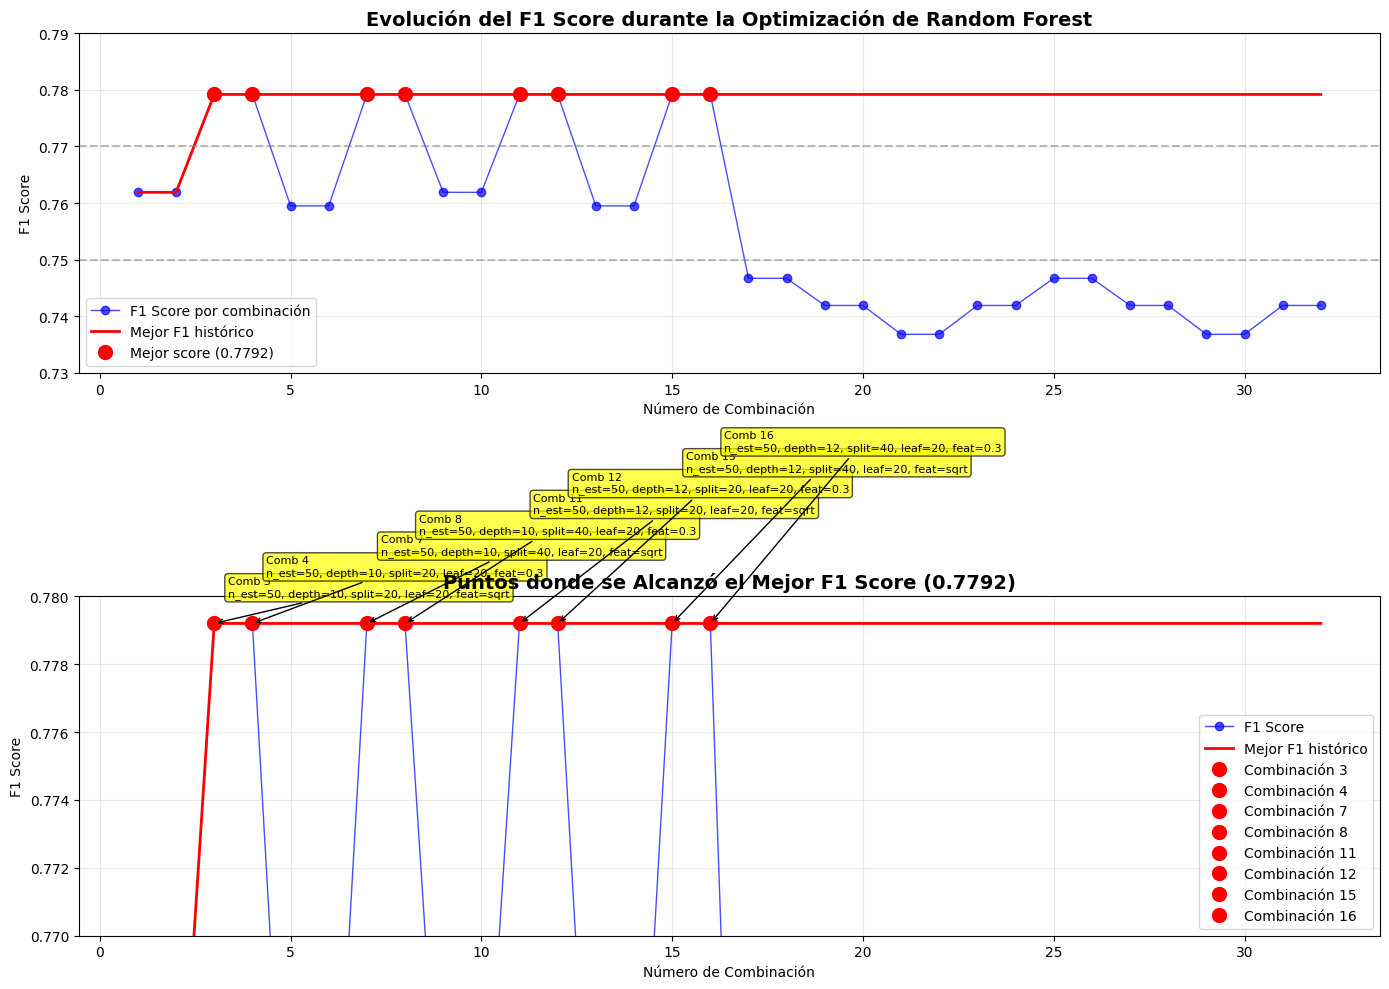

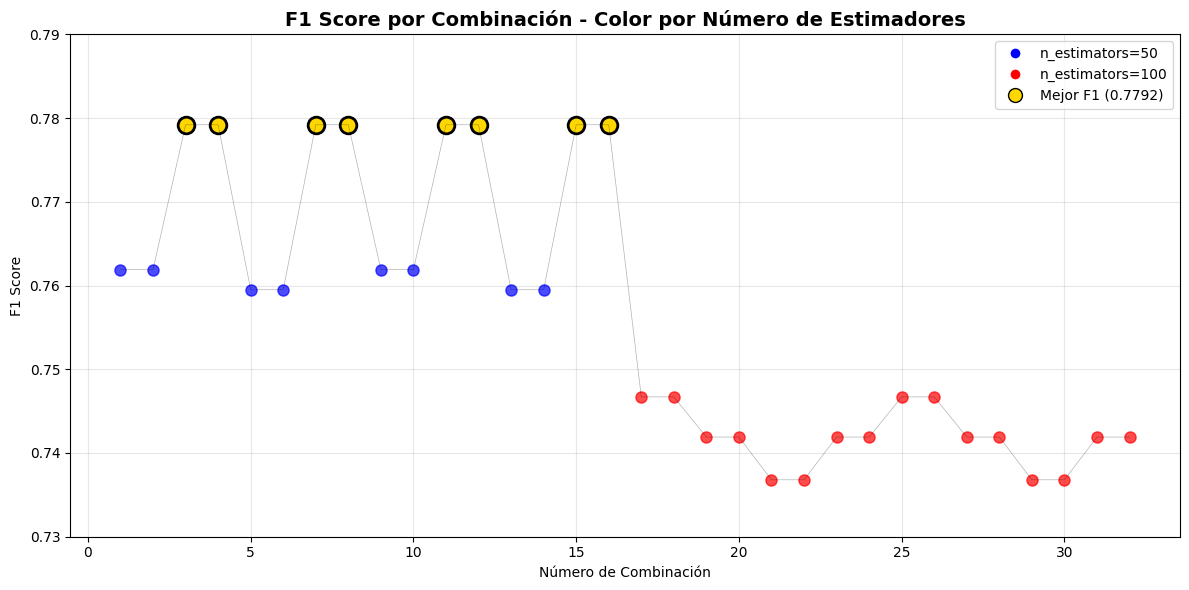

RESUMEN ESTADÍSTICO DE LA OPTIMIZACIÓN
Total de combinaciones probadas: 32
Mejor F1 score: 0.7792
Peor F1 score: 0.7368
F1 score promedio: 0.7559
Desviación estándar: 0.0157
Combinaciones con F1 ≥ 0.77: 8
Combinaciones con F1 ≥ 0.78: 0
Mejor score alcanzado en la combinación: 3


In [52]:
# Datos de tus resultados
iterations = list(range(1, 33))  # 32 combinaciones probadas

f1_scores = [
    0.7619, 0.7619, 0.7792, 0.7792, 0.7595, 0.7595, 0.7792, 0.7792,
    0.7619, 0.7619, 0.7792, 0.7792, 0.7595, 0.7595, 0.7792, 0.7792,
    0.7467, 0.7467, 0.7419, 0.7419, 0.7368, 0.7368, 0.7419, 0.7419,
    0.7467, 0.7467, 0.7419, 0.7419, 0.7368, 0.7368, 0.7419, 0.7419
]

# Calcular el mejor F1 histórico en cada punto
best_f1_history = []
current_best = -1
for score in f1_scores:
    if score > current_best:
        current_best = score
    best_f1_history.append(current_best)

# Crear los gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# GRÁFICO 1: Evolución completa del F1 Score
ax1.plot(iterations, f1_scores, 'bo-', linewidth=1, markersize=6, alpha=0.7, label='F1 Score por combinación')
ax1.plot(iterations, best_f1_history, 'r-', linewidth=2, label='Mejor F1 histórico')

# Resaltar los puntos donde se alcanzó el mejor score
best_indices = [i for i, score in enumerate(f1_scores) if score == max(f1_scores)]
for idx in best_indices:
    ax1.plot(iterations[idx], f1_scores[idx], 'ro', markersize=10, 
             label='Mejor score (0.7792)' if idx == best_indices[0] else "")

ax1.set_xlabel('Número de Combinación')
ax1.set_ylabel('F1 Score')
ax1.set_title('Evolución del F1 Score durante la Optimización de Random Forest', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.73, 0.79)

# Añadir líneas de referencia
ax1.axhline(y=0.75, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=0.77, color='gray', linestyle='--', alpha=0.5)

# GRÁFICO 2: Enfoque en las mejores combinaciones
ax2.plot(iterations, f1_scores, 'bo-', linewidth=1, markersize=6, alpha=0.7, label='F1 Score')
ax2.plot(iterations, best_f1_history, 'r-', linewidth=2, label='Mejor F1 histórico')

# Resaltar las combinaciones que alcanzaron el mejor score
for idx in best_indices:
    ax2.plot(iterations[idx], f1_scores[idx], 'ro', markersize=10, markerfacecolor='red', 
             label=f'Combinación {iterations[idx]}' if idx == best_indices[0] else f'Combinación {iterations[idx]}')

ax2.set_xlabel('Número de Combinación')
ax2.set_ylabel('F1 Score')
ax2.set_title('Puntos donde se Alcanzó el Mejor F1 Score (0.7792)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.77, 0.78)  # Zoom en el rango del mejor score

# Añadir anotaciones con los parámetros de las mejores combinaciones
best_params_info = [
    "n_est=50, depth=10, split=20, leaf=20, feat=sqrt",
    "n_est=50, depth=10, split=20, leaf=20, feat=0.3", 
    "n_est=50, depth=10, split=40, leaf=20, feat=sqrt",
    "n_est=50, depth=10, split=40, leaf=20, feat=0.3",
    "n_est=50, depth=12, split=20, leaf=20, feat=sqrt",
    "n_est=50, depth=12, split=20, leaf=20, feat=0.3",
    "n_est=50, depth=12, split=40, leaf=20, feat=sqrt",
    "n_est=50, depth=12, split=40, leaf=20, feat=0.3"
]

for i, idx in enumerate(best_indices):
    if i < len(best_params_info):
        ax2.annotate(f'Comb {iterations[idx]}\n{best_params_info[i]}', 
                    xy=(iterations[idx], f1_scores[idx]),
                    xytext=(10, 20 + i*15), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                    fontsize=8)

plt.tight_layout()
plt.show()

# Gráfico adicional: Comparación por grupos de parámetros
fig, ax3 = plt.subplots(figsize=(12, 6))

# Colorear por número de estimadores
colors = ['blue'] * 16 + ['red'] * 16  # Primeras 16: n_est=50, últimas 16: n_est=100

for i, (x, y, color) in enumerate(zip(iterations, f1_scores, colors)):
    ax3.plot(x, y, 'o', color=color, markersize=8, alpha=0.7)
    if y == max(f1_scores):
        ax3.plot(x, y, 'o', color='gold', markersize=12, markeredgecolor='black', markeredgewidth=2)

# Línea de tendencia
ax3.plot(iterations, f1_scores, 'k-', linewidth=0.5, alpha=0.3)

ax3.set_xlabel('Número de Combinación')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score por Combinación - Color por Número de Estimadores', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0.73, 0.79)

# Leyenda personalizada
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='n_estimators=50'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='n_estimators=100'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=10, 
           markeredgecolor='black', label='Mejor F1 (0.7792)')
]
ax3.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# Resumen estadístico
print("="*60)
print("RESUMEN ESTADÍSTICO DE LA OPTIMIZACIÓN")
print("="*60)
print(f"Total de combinaciones probadas: {len(f1_scores)}")
print(f"Mejor F1 score: {max(f1_scores):.4f}")
print(f"Peor F1 score: {min(f1_scores):.4f}")
print(f"F1 score promedio: {np.mean(f1_scores):.4f}")
print(f"Desviación estándar: {np.std(f1_scores):.4f}")
print(f"Combinaciones con F1 ≥ 0.77: {sum(score >= 0.77 for score in f1_scores)}")
print(f"Combinaciones con F1 ≥ 0.78: {sum(score >= 0.78 for score in f1_scores)}")
print(f"Mejor score alcanzado en la combinación: {best_indices[0] + 1}")
print("="*60)

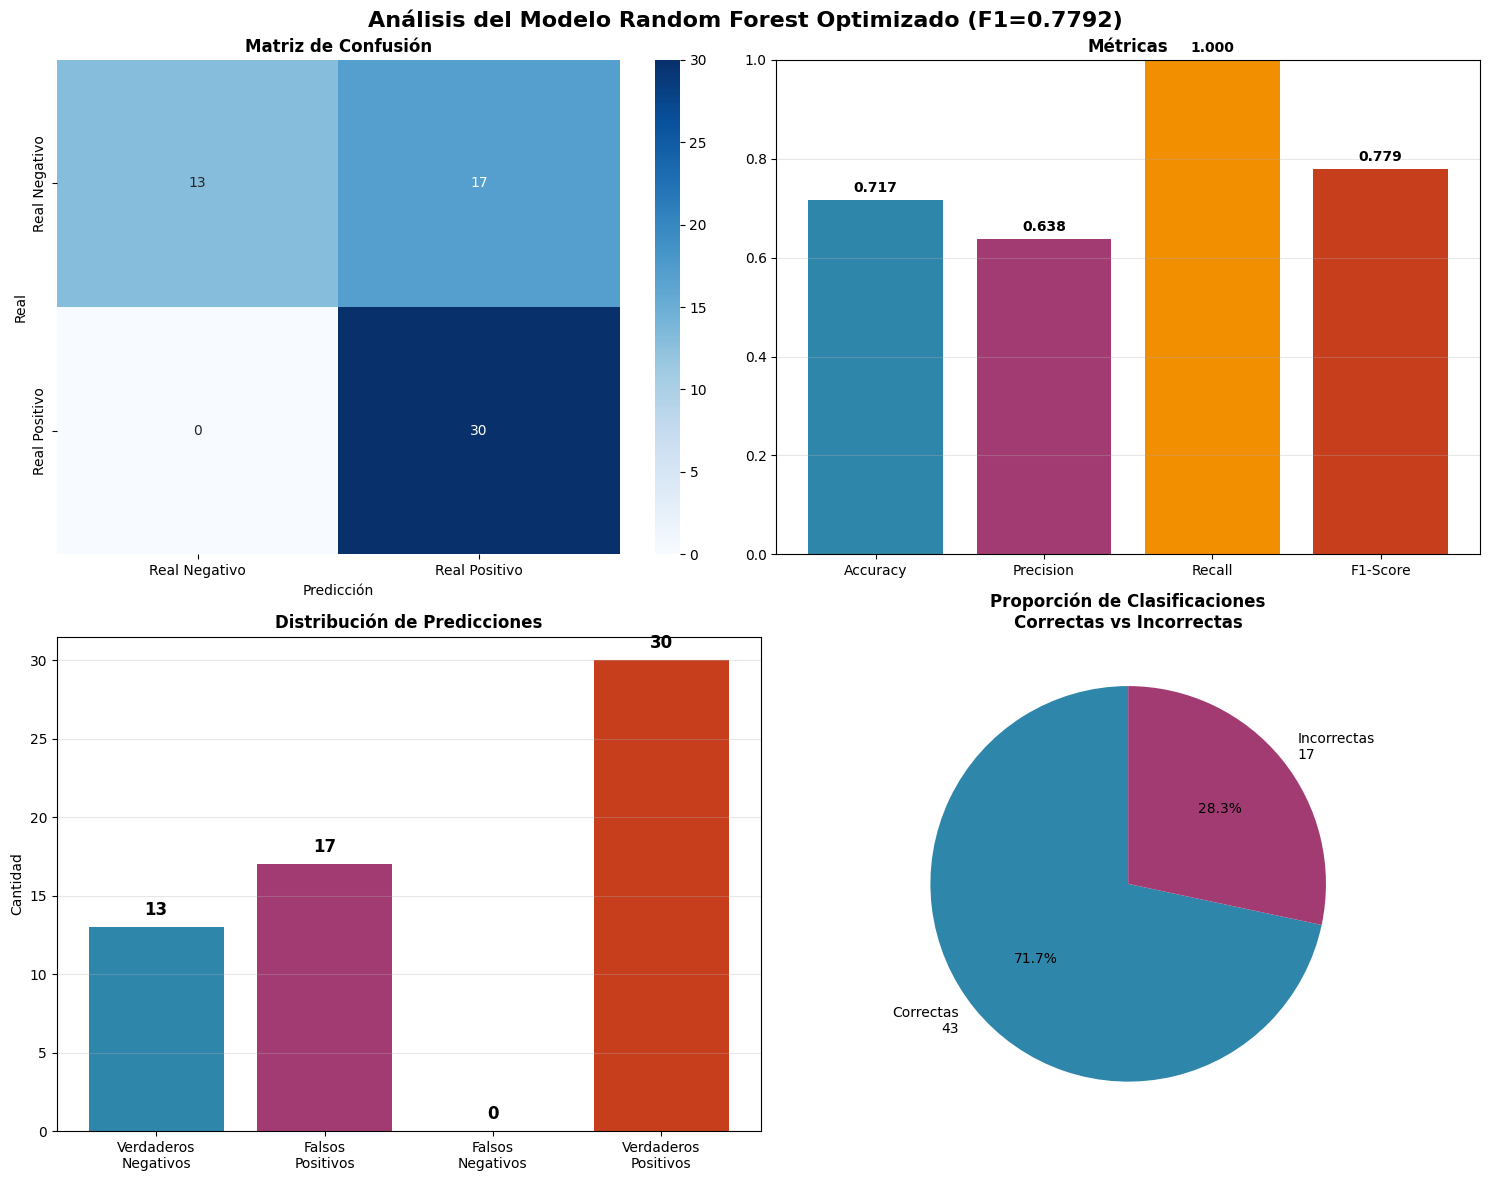

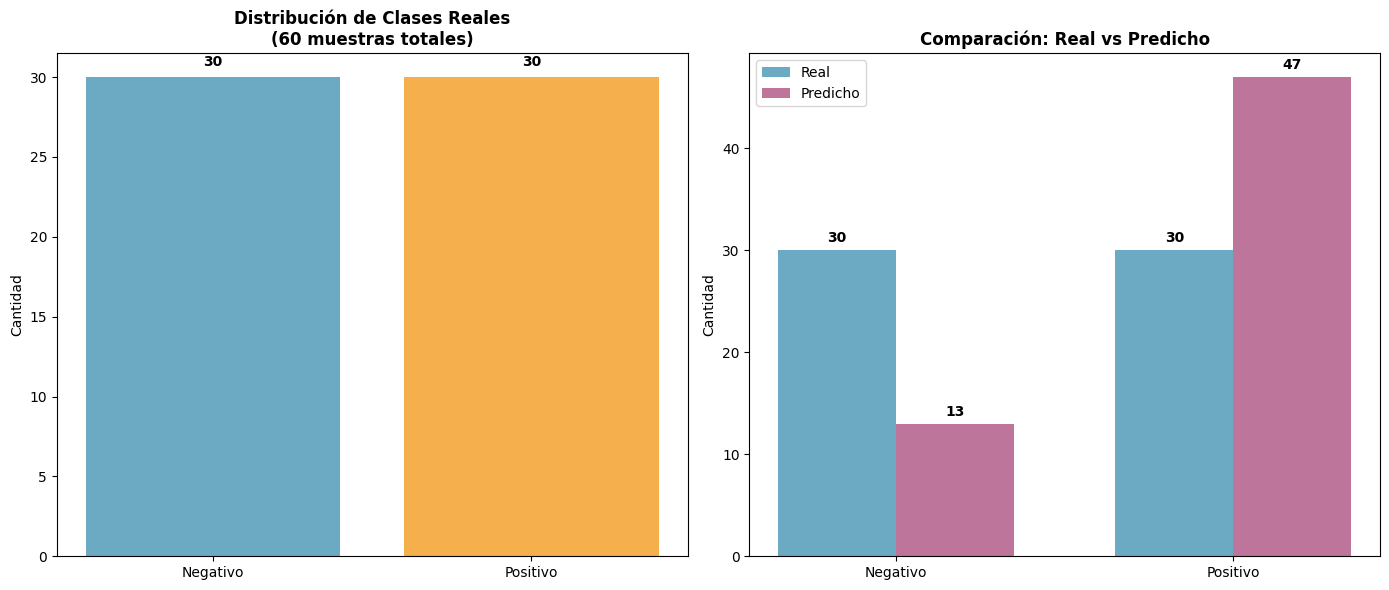

RESUMEN DEL MODELO RANDOM FOREST
📊 Total de muestras: 60
🎯 Threshold óptimo: 0.243
⭐ F1-Score: 0.7792
📈 Accuracy: 0.717
🎯 Precision: 0.638
🔍 Recall: 1.000
✅ Verdaderos Positivos: 30
✅ Verdaderos Negativos: 13
❌ Falsos Positivos: 17
❌ Falsos Negativos: 0
📊 Proporción correctas: 71.7%


In [49]:
# Datos de la matriz de confusión
cm = np.array([[13, 17],
               [0, 30]])

tn, fp, fn, tp = cm.ravel()

# Configuración de estilo
plt.style.use('default')
sns.set_palette("husl")

# 1. MATRIZ DE CONFUSIÓN HEATMAP
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis del Modelo Random Forest Optimizado (F1=0.7792)', fontsize=16, fontweight='bold')

# Heatmap de matriz de confusión
labels = ['Real Negativo', 'Real Positivo']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_title('Matriz de Confusión', fontweight='bold')
ax1.set_xlabel('Predicción')
ax1.set_ylabel('Real')

# 2. GRÁFICO DE BARRAS DE MÉTRICAS
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [
    (tp + tn) / cm.sum(),  # Accuracy
    tp / (tp + fp) if (tp + fp) > 0 else 0,  # Precision
    tp / (tp + fn) if (tp + fn) > 0 else 0,  # Recall
    0.7792  # F1-Score
]

bars = ax2.bar(metrics, values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
ax2.set_title('Métricas', fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. GRÁFICO DE DISTRIBUCIÓN DE PREDICCIONES
categories = ['Verdaderos\nNegativos', 'Falsos\nPositivos', 'Falsos\nNegativos', 'Verdaderos\nPositivos']
counts = [tn, fp, fn, tp]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

ax3.bar(categories, counts, color=colors)
ax3.set_title('Distribución de Predicciones', fontweight='bold')
ax3.set_ylabel('Cantidad')
ax3.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (category, count) in enumerate(zip(categories, counts)):
    ax3.text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)

# 4. GRÁFICO PIE CHART DE CLASIFICACIÓN
correct_predictions = tn + tp
incorrect_predictions = fp + fn
sizes = [correct_predictions, incorrect_predictions]
labels_pie = [f'Correctas\n{correct_predictions}', f'Incorrectas\n{incorrect_predictions}']
colors_pie = ['#2E86AB', '#A23B72']

ax4.pie(sizes, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax4.set_title('Proporción de Clasificaciones\nCorrectas vs Incorrectas', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. GRÁFICO ADICIONAL: COMPARATIVA ENTRE CLASES REALES VS PREDICHAS
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(14, 6))

# Distribución de clases reales
real_classes = ['Negativo', 'Positivo']
real_counts = [tn + fp, fn + tp]  # Realmente 30 negativos (13+17) y 30 positivos (0+30)

ax5.bar(real_classes, real_counts, color=['#2E86AB', '#F18F01'], alpha=0.7)
ax5.set_title('Distribución de Clases Reales\n(60 muestras totales)', fontweight='bold')
ax5.set_ylabel('Cantidad')
for i, count in enumerate(real_counts):
    ax5.text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

# Distribución de predicciones vs real
width = 0.35
x = np.arange(len(real_classes))
real_bars = ax6.bar(x - width/2, real_counts, width, label='Real', color='#2E86AB', alpha=0.7)
pred_bars = ax6.bar(x + width/2, [tn + fn, fp + tp], width, label='Predicho', color='#A23B72', alpha=0.7)

ax6.set_title('Comparación: Real vs Predicho', fontweight='bold')
ax6.set_ylabel('Cantidad')
ax6.set_xticks(x)
ax6.set_xticklabels(real_classes)
ax6.legend()

# Añadir valores en las barras
for bar in real_bars + pred_bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             str(int(height)), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 6. RESUMEN NUMÉRICO
print("="*50)
print("RESUMEN DEL MODELO RANDOM FOREST")
print("="*50)
print(f"📊 Total de muestras: {cm.sum()}")
print(f"🎯 Threshold óptimo: 0.243")
print(f"⭐ F1-Score: 0.7792")
print(f"📈 Accuracy: {(tp+tn)/cm.sum():.3f}")
print(f"🎯 Precision: {tp/(tp+fp):.3f}")
print(f"🔍 Recall: {tp/(tp+fn):.3f}")
print(f"✅ Verdaderos Positivos: {tp}")
print(f"✅ Verdaderos Negativos: {tn}")
print(f"❌ Falsos Positivos: {fp}")
print(f"❌ Falsos Negativos: {fn}")
print(f"📊 Proporción correctas: {(tp+tn)/cm.sum():.1%}")
print("="*50)

# Test final

In [100]:
X_final = pd.read_csv(r"c:\Users\USER\Downloads\x_test_final.csv")
X_final

,value__permutation_entropy__dimension_3__tau_1,value__partial_autocorrelation__lag_3,value__ar_coefficient__coeff_2__k_10,value__number_cwt_peaks__n_1,"value__fft_aggregated__aggtype_""kurtosis""",value__absolute_maximum,"value__fft_coefficient__attr_""abs""__coeff_63",value__value_count__value_0,value__ratio_value_number_to_time_series_length,"value__fft_coefficient__attr_""real""__coeff_59",value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__standard_deviation,"value__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.2"
0,1.088459,0.758803,-1.569991,630.0,38.293312,0.553009,17.683124,3.0,0.455046,-13.261270,0.785321,0.100764,0.000002
1,1.330092,-0.415272,0.370386,857.0,6.672080,0.086639,1.264729,42.0,0.113546,0.956997,0.964544,0.010618,0.000002
2,1.168164,0.234469,-1.016020,715.0,18.891742,0.134186,2.279622,13.0,0.178683,2.799270,0.953211,0.020876,0.000006
3,1.336187,-0.387853,-0.047466,924.0,12.438693,0.127472,1.295404,21.0,0.171236,0.281815,0.945116,0.019956,0.000005
4,1.195760,0.126332,-1.464534,754.0,12.930023,0.291809,4.690593,9.0,0.264436,-3.296787,0.889584,0.042075,-0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1.454446,-0.518266,0.524704,1083.0,12.675042,0.399963,2.051219,12.0,0.258068,1.343294,0.901835,0.043169,0.000010
201,1.302857,0.314087,-0.696567,918.0,4.469840,0.200134,10.880192,3.0,0.285483,-3.055885,0.906692,0.040257,-0.000053
202,1.710468,-0.037047,0.360648,1201.0,4.493884,0.290131,2.441197,37.0,0.132920,2.524771,0.946303,0.014041,0.000008
203,1.135978,0.505003,-1.778731,516.0,28.132993,1.000000,34.399320,8.0,0.427469,11.900385,0.771722,0.171011,-0.000035


In [101]:
scaler = StandardScaler()
Equia = scaler.fit_transform(X_final)
Equia

array([[-1.45376517,  1.92331675, -1.32793281, ..., -1.70168856,
         1.19425626,  0.19318402],
       [-0.23217282, -0.88683307,  1.07278638, ...,  1.01308978,
        -0.8153573 ,  0.18721627],
       [-1.05081374,  0.66832226, -0.6425355 , ...,  0.84142358,
        -0.58669176,  0.25461912],
       ...,
       [ 1.69084553,  0.01844744,  1.06073875, ...,  0.73678894,
        -0.73905086,  0.28609731],
       [-1.21353132,  1.31584458, -1.58619466, ..., -1.907688  ,
         2.76026177, -0.46377873],
       [-0.07999247, -1.22188444,  1.49296211, ..., -0.6962151 ,
         0.46269777, -0.54750265]], shape=(205, 13))

In [102]:
result = rf.predict(Equia)
result

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0])

In [98]:
submission = pd.DataFrame({
    'ID': np.arange(1, len(result) + 1),
    'result': result
})
submission.to_csv('submission.csv', index=False)